/usr/local/lib/python3.10/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


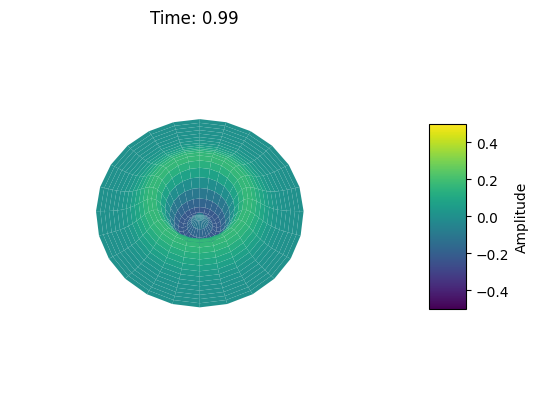

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from scipy.sparse.linalg import splu

# Define grid size, radius, and time step
N = 50
R = 1
dt = 0.005

# Create the spatial grid
theta, r = np.linspace(0, 2*np.pi, N//2), np.linspace(0, R, N//2)
grid_theta, grid_r = np.meshgrid(theta, r)
grid_x, grid_y = grid_r * np.cos(grid_theta), grid_r * np.sin(grid_theta)

# Define the wave speed
c = 1

# Create Laplacian matrix
A = np.zeros((N//2, N//2))
A[0, 0] = -2
A[0, 1] = 1
A[-1, -2] = 1
A[-1, -1] = -2

for i in range(1, N//2-1):
    A[i, i-1] = 1
    A[i, i] = -2
    A[i, i+1] = 1

A *= c**2 / (R/N)**2

# Perform LU decomposition of (I - dt^2/2*A)
I = np.identity(N//2)
lu = splu(I - (dt**2 / 2) * A)

# Initial conditions - circular Gaussian hit at the center
init_func = lambda r, sigma: np.exp(-r**2 / (2 * sigma**2))
sigma = 0.1
u0 = init_func(grid_r, sigma)
u1 = u0.copy()

# Animation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax._axis3don = False  # Hide the 3D axes
ax.grid(False)  # Disable grid lines

def init():
    ax.view_init(elev=65, azim=-90)
    ax.set_zlim(-0.5, 0.5)
    ax.set_title("Time: 0.00")

def update(frame):
    global u0, u1

    # Compute the next time step
    u2 = 2 * u1 - u0 + dt**2 * (A @ u1)
    u2 = lu.solve(u2)  # Apply the inverse of (I - dt^2/2*A)

    # Update the surface plot
    ax.clear()
    ax.view_init(elev=65, azim=-90)
    surf = ax.plot_surface(grid_x, grid_y, u2, cmap=cm.viridis, vmin=-0.5, vmax=0.5, antialiased=True)
    ax.set_zlim(-0.5, 0.5)
    ax.set_title(f"Time: {frame*dt:.2f}")
    ax._axis3don = False  # Hide the 3D axes
    ax.grid(False)  # Disable grid lines

    # Shift the solution arrays
    u0, u1 = u1, u2
    return surf,

ani = animation.FuncAnimation(fig, update, frames=200, init_func=init, interval=20, blit=False, repeat=False)

# Add the color map and title
cbar = fig.colorbar(cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=-0.5, vmax=0.5)), ax=ax, shrink=0.5, aspect=5, pad=0.1)
cbar.ax.set_ylabel('Amplitude')  # Add title to colorbar

# Save the animation as an MP4 file
ani.save('wave_simulation.mp4', writer='ffmpeg')

plt.show()
